# Spam Detection

This dataset can be imported directly from this github link:
 https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

The SMS Spam Collection is a dataset containing 5,574 SMS messages in English along with the label Spam or Ham (not spam).

Our goal is to train a machine learning model that will learn from the text of SMS and the label and be able to predict the class of SMS messages.


In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras

import nltk
import gensim
import re
import string
import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Read Data
data = pd.read_csv('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv', encoding='latin-1')

data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Drop Unnecessary columns
columns_to_drop = ['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4']

data.drop(columns = columns_to_drop, inplace = True)

data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

In [ ]:
# Shape of Data
data.shape

(5572, 2)

In [ ]:
# Checking non null counts of each feature and its type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


We don't have null value, thats why we are not going to look further more
____

v1
ham     4825
spam     747
Name: count, dtype: int64


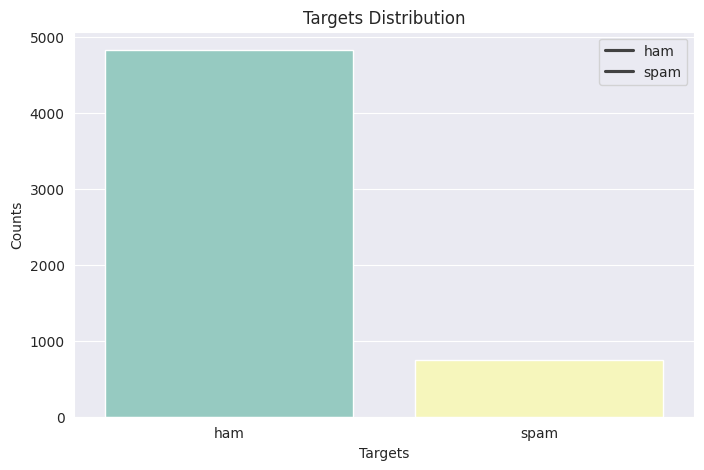

In [ ]:
# Lets visualize targets counts
targets_counts = data['v1'].value_counts()
print(targets_counts)

# Plot
plt.figure(figsize = (8,5))
sns.set_style('darkgrid')
sns.barplot(x = targets_counts.index, y = targets_counts.values,
            hue =targets_counts.index, palette = 'Set3', legend = False)
plt.title('Targets Distribution')
plt.legend(['ham', 'spam'])
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.show()

As we can see we have imbalanced targets

# Text Preprocessing

In [ ]:
# Defining Preprocessing Function
def preprocess_data(data):

  # lowercasing
  data = data.lower()

  # punctuation removal
  data = data.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

  # remove non-alphabetic
  data = re.sub(r'[^a-zA-Z]+', ' ', data)

  # removing numeric if existing
  data = re.sub(r'\d+',' ', data)

  #Remove extra space and tabs
  data = re.sub('\s+', ' ', data)

  # Lemmatizing (but first we need tokens and stop-words removing)
  tokens = word_tokenize(data)

  stop_words = stopwords.words('english')

  words = [word for word in tokens if word not in stop_words]

  lemma = WordNetLemmatizer()

  words = [lemma.lemmatize(word) for word in words]

  # joining words
  data = ' '.join(words)

  return data

In [ ]:
# Apply preprocess function to whole dataset
tqdm.tqdm.pandas()

data['v2'] = data['v2'].progress_apply(preprocess_data)

100%|██████████| 5572/5572 [00:10<00:00, 509.17it/s]


In [ ]:
data.head()

,v1,v2
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though


### Train-test split

In [ ]:
# Define X and y
X = data['v2']
y = data['v1']

# Split on train and test
X_train,X_test,y_train,y_test = train_test_split(X,y, shuffle=True,
                                                 random_state = 42,
                                                 test_size = 0.2)

# Shapes
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (4457,)
Test Shape: (1115,)


In [ ]:
# Labels encoding (i will use label encoding, also we can use one hot)
le = LabelEncoder()
y_encoded_train = le.fit_transform(y_train)
y_encoded_test = le.transform(y_test)

# converting to floats
y_encoded_train = y_encoded_train.astype('float32')
y_encoded_test = y_encoded_test.astype('float32')

In [ ]:
print(y_encoded_train) # ham -> 0, spam -> 1

[0. 1. 0. ... 0. 0. 0.]


## Feature Extraction

In this project i will try using CountVectorizer, Tfidf vectorizer

In [ ]:
# CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit
X_cv_train = cv.fit_transform(X_train)
X_cv_test = cv.transform(X_test)

#shape
X_cv_train.shape, X_cv_test.shape

((4457, 6102), (1115, 6102))

In [ ]:
print(cv.get_feature_names_out()[10:20])

['abi' 'ability' 'abiola' 'abj' 'able' 'abnormally' 'aboutas' 'abroad'
 'absolutly' 'abstract']


In [ ]:
# Tfidf Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

#Fit
X_tfidf_train = tfidf.fit_transform(X_train)
X_tfidf_test = tfidf.transform(X_test)

# shape
X_tfidf_train.shape,X_tfidf_test.shape

((4457, 6102), (1115, 6102))

In [ ]:
print(tfidf.get_feature_names_out()[10:20])

['abi' 'ability' 'abiola' 'abj' 'able' 'abnormally' 'aboutas' 'abroad'
 'absolutly' 'abstract']


# Building Models

### With CountVectorizer

Accuracy score on test: 0.97847533632287
Accuracy score on train: 0.9937177473636976 

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       965
         1.0       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 



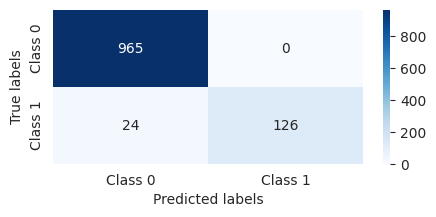

In [ ]:
# Logistic regression
lr = LogisticRegression(random_state = 42)

#fit
lr.fit(X_cv_train,y_encoded_train)

#predict
y_cv_lr = lr.predict(X_cv_test)

#evaluate (calculating both accuracy score to check for overfitting)
print('Accuracy score on test:', accuracy_score(y_encoded_test,y_cv_lr))
print('Accuracy score on train:', accuracy_score(y_encoded_train,lr.predict(X_cv_train)),'\n')

print(classification_report(y_encoded_test,y_cv_lr),'\n')

# Confusion matrix
plt.figure(figsize=(5, 2))
sns.heatmap(confusion_matrix(y_encoded_test,y_cv_lr),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy score on test: 0.8923766816143498 

Accuracy score on train: 0.9937177473636976 

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       965
         1.0       1.00      0.20      0.33       150

    accuracy                           0.89      1115
   macro avg       0.94      0.60      0.64      1115
weighted avg       0.90      0.89      0.86      1115
 



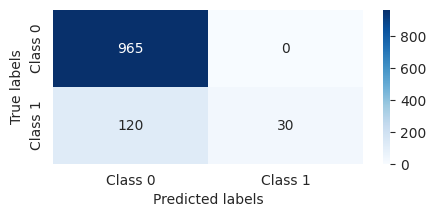

In [ ]:
# RandomForest
rf = RandomForestClassifier(max_depth = 10, random_state = 42)

#fit
rf.fit(X_cv_train,y_encoded_train)

#predict
y_cv_rf = rf.predict(X_cv_test)

#evaluate
print('Accuracy score on test:', accuracy_score(y_encoded_test,y_cv_rf), '\n')
print('Accuracy score on train:', accuracy_score(y_encoded_train,lr.predict(X_cv_train)),'\n')

print(classification_report(y_encoded_test,y_cv_rf), '\n')

# Confusion matrix
plt.figure(figsize=(5, 2))
sns.heatmap(confusion_matrix(y_encoded_test,y_cv_rf),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy score on test: 0.9766816143497757
Accuracy score on train: 0.9957370428539376 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       965
         1.0       0.99      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 



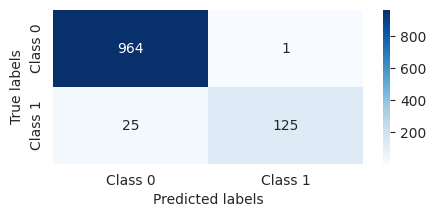

In [ ]:
# SVC
svc = SVC(random_state = 42)

#fit
svc.fit(X_cv_train,y_encoded_train)

#predict
y_cv_svm = svc.predict(X_cv_test)

#evaluate
print('Accuracy score on test:', accuracy_score(y_encoded_test,y_cv_svm))
print('Accuracy score on train:', accuracy_score(y_encoded_train,svc.predict(X_cv_train)), '\n')

print(classification_report(y_encoded_test,y_cv_svm), '\n')

# Confusion matrix
plt.figure(figsize=(5, 2))
sns.heatmap(confusion_matrix(y_encoded_test,y_cv_svm),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### With Tf-ifg vectorizer

Accuracy score on test: 0.9542600896860987
Accuracy score on train: 0.9712811308054745 

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       965
         1.0       0.97      0.68      0.80       150

    accuracy                           0.95      1115
   macro avg       0.96      0.84      0.89      1115
weighted avg       0.96      0.95      0.95      1115
 



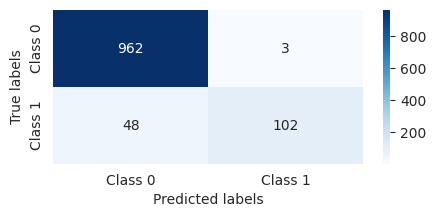

In [ ]:
# LogisticRegression
lr1 = LogisticRegression(random_state = 42)

#fit
lr1.fit(X_tfidf_train,y_encoded_train)

# predict
y_tfidf_lr = lr1.predict(X_tfidf_test)

#evaluate
print('Accuracy score on test:', accuracy_score(y_encoded_test,y_tfidf_lr))
print('Accuracy score on train:', accuracy_score(y_encoded_train,lr1.predict(X_tfidf_train)), '\n')

print(classification_report(y_encoded_test,y_tfidf_lr),'\n')

# Confusion matrix
plt.figure(figsize = (5,2))
sns.heatmap(confusion_matrix(y_encoded_test,y_tfidf_lr),
            annot = True, fmt = 'd',
            cmap = 'Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plt.show()


Accuracy score on test: 0.8932735426008969
Accuracy score on train: 0.9071124074489567 

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       965
         1.0       1.00      0.21      0.34       150

    accuracy                           0.89      1115
   macro avg       0.95      0.60      0.64      1115
weighted avg       0.90      0.89      0.86      1115
 



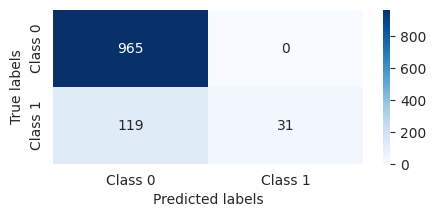

In [ ]:
# Random Forest
rf1 = RandomForestClassifier(max_depth = 10, random_state = 42)

#fit
rf1.fit(X_tfidf_train,y_encoded_train)

# predict
y_tfidf_rf = rf1.predict(X_tfidf_test)

#evaluate
print('Accuracy score on test:', accuracy_score(y_encoded_test,y_tfidf_rf))
print('Accuracy score on train:', accuracy_score(y_encoded_train,rf1.predict(X_tfidf_train)), '\n')

print(classification_report(y_encoded_test,y_tfidf_rf),'\n')

# Confusion matrix
plt.figure(figsize = (5,2))
sns.heatmap(confusion_matrix(y_encoded_test,y_tfidf_rf),
            annot = True, fmt = 'd',
            cmap = 'Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plt.show()

Accuracy score on test: 0.9757847533632287
Accuracy score on train: 0.9977563383441777 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       965
         1.0       0.99      0.83      0.90       150

    accuracy                           0.98      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115
 



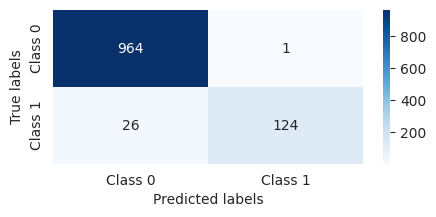

In [ ]:
# SVC
svc1 = SVC(random_state = 42)

#fit
svc1.fit(X_tfidf_train,y_encoded_train)

# predict
y_tfidf_svc = svc1.predict(X_tfidf_test)

#evaluate
print('Accuracy score on test:', accuracy_score(y_encoded_test,y_tfidf_svc))
print('Accuracy score on train:', accuracy_score(y_encoded_train,svc1.predict(X_tfidf_train)),'\n')

print(classification_report(y_encoded_test,y_tfidf_svc),'\n')

# Confusion matrix
plt.figure(figsize = (5,2))
sns.heatmap(confusion_matrix(y_encoded_test,y_tfidf_svc),
            annot = True, fmt = 'd',
            cmap = 'Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plt.show()

# Summary

In [ ]:
# Scores and models
scores = [accuracy_score(y_encoded_test,y_cv_lr),
          accuracy_score(y_encoded_test,y_cv_rf),
          accuracy_score(y_encoded_test,y_cv_svm),
          accuracy_score(y_encoded_test,y_tfidf_lr),
          accuracy_score(y_encoded_test,y_tfidf_rf),
          accuracy_score(y_encoded_test,y_tfidf_svc)]

names = ['Bow LogisticRegression','Bow RandomForest','Bow SVC',
         'Tfidf LogisticRegression', 'Tfidf RandomForest', 'Tfidf SVC']


In [ ]:
data = {'models': names, 'accuracy':scores}
df_scores = pd.DataFrame(data)
df_scores.sort_values('accuracy', ascending = False)

,models,accuracy
0,Bow LogisticRegression,0.978475
2,Bow SVC,0.976682
5,Tfidf SVC,0.975785
3,Tfidf LogisticRegression,0.954260
4,Tfidf RandomForest,0.893274
1,Bow RandomForest,0.892377


Best model for Spam Detection is Logistic Regression with **CountVectorizer**

# Prediction

In [ ]:
# Save best model
import pickle

model_pkl_file = "spam_detection_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(lr, file)

In [ ]:
# Load best model
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

# evaluate
y_predict = model.predict(X_cv_test)
print('Accuracy score ', accuracy_score(y_encoded_test,y_predict))


Accuracy score  0.97847533632287


In [ ]:
text_sample =[ '''Congratulations! You've Won a Free Vacation

              Dear Valentina,

              We are thrilled to inform you that you have been selected as the lucky winner of our exclusive vacation giveaway!
              You and a companion are entitled to a luxurious 5-day, 4-night stay at a world-class resort in the Caribbean.

              To claim your prize, simply click on the link below and provide us with your contact details within the next 24 hours:

              But hurry, this offer is only available for a limited time! Don't miss out on this amazing opportunity to enjoy a dream vacation on us.

              Best regards,
              Vavilon Hotel''']


In [ ]:
print(text_sample)

["Congratulations! You've Won a Free Vacation\n\n              Dear Valentina,\n\n              We are thrilled to inform you that you have been selected as the lucky winner of our exclusive vacation giveaway! \n              You and a companion are entitled to a luxurious 5-day, 4-night stay at a world-class resort in the Caribbean.\n\n              To claim your prize, simply click on the link below and provide us with your contact details within the next 24 hours:\n\n              But hurry, this offer is only available for a limited time! Don't miss out on this amazing opportunity to enjoy a dream vacation on us.\n\n              Best regards,\n              Vavilon Hotel"]


In [ ]:
# step 1 preprocess data
preprocessed_text_sample = preprocess_data(text_sample[0])

In [ ]:
# step 2: vectorize
vect_text = cv.transform([preprocessed_text_sample])

In [ ]:
# Calculate prediction probability

# ham -> 0, spam -> 1
y_pred = model.predict_proba(vect_text)
print('Probability of this message to be ham:', y_pred[0][0])
print('Probability of this message to be spam:', y_pred[0][1])

Probability of this message to be ham: 0.0013138438851192369
Probability of this message to be spam: 0.9986861561148808


# Prediction of this model is that the message is spam!